
Original features: 10
PCA-reduced features: 5
KNN model trained and saved.


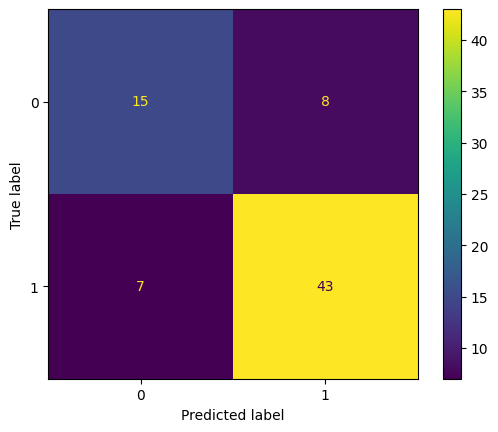


Enter weather parameters for prediction:


Atmospheric pressure (hPa):  1022
Maximum temperature (°C):  19
Current temperature (°C):  18
Minimum temperature (°C):  17
Dew point temperature (°C):  10
Humidity (%):  20
Cloud cover (%):  10
Sunshine hours:  8
Wind direction (degrees):  40
Wind speed (km/h):  19



Rainfall Prediction: No
Confidence: 0.0%

Model Performance:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        23
           1       0.84      0.86      0.85        50

    accuracy                           0.79        73
   macro avg       0.76      0.76      0.76        73
weighted avg       0.79      0.79      0.79        73



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import os

def get_float_input(prompt):
    while True:
        try:
            return float(input(prompt))
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_weather_input():
    print("\nEnter weather parameters for prediction:")
    return {
        'pressure': get_float_input("Atmospheric pressure (hPa): "),
        'maxtemp': get_float_input("Maximum temperature (°C): "),
        'temparature': get_float_input("Current temperature (°C): "),
        'mintemp': get_float_input("Minimum temperature (°C): "),
        'dewpoint': get_float_input("Dew point temperature (°C): "),
        'humidity': get_float_input("Humidity (%): "),
        'cloud': get_float_input("Cloud cover (%): "),
        'sunshine': get_float_input("Sunshine hours: "),
        'winddirection': get_float_input("Wind direction (degrees): "),
        'windspeed': get_float_input("Wind speed (km/h): ")
    }

# Load and preprocess dataset
df = pd.read_csv('Rainfall.csv')
df.columns = df.columns.str.strip()
df['rainfall_label'] = df['rainfall'].map({'yes': 1, 'no': 0})
df = df.dropna()

feature_cols = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
                'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
X = df[feature_cols].fillna(df[feature_cols].mean(numeric_only=True))
y = df['rainfall_label']

# Scale and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nOriginal features: {X_scaled.shape[1]}")
print(f"PCA-reduced features: {X_pca.shape[1]}")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Model training or loading
model_path = 'knn_pca_model.pkl'

if os.path.exists(model_path):
    model = joblib.load(model_path)
    print("Model loaded from file.")
else:
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    joblib.dump(model, model_path)
    print("KNN model trained and saved.")

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

# Predict on user input
user_data = pd.DataFrame([get_weather_input()])
user_scaled = scaler.transform(user_data)
user_pca = pca.transform(user_scaled)

pred_proba = model.predict_proba(user_pca)[0][1]
prediction = model.predict(user_pca)

print(f"\nRainfall Prediction: {'Yes' if prediction[0] else 'No'}")
print(f"Confidence: {pred_proba:.1%}")

# Model performance
print("\nModel Performance:")
print(classification_report(y_test, model.predict(X_test)))
